Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
!pip install tensorflow

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from glob import glob
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom,RandomContrast
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models

import Augmentor

import warnings
warnings.filterwarnings("ignore")

# Data Reading/Data Understanding

Defining the path for train and test images

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
!pip install --upgrade Pillow

In [5]:
# Importing Skin Cancer Data
# Defining the path for train and test images
curr_dir_path = pathlib.Path('/Users/CL272FV/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration')
print("Current Working Directory:", curr_dir_path)

base_path = pathlib.Path(curr_dir_path)
ds_subdir = "Skin cancer ISIC The International Skin Imaging Collaboration"
path_to_training_dataset = base_path / "Train"
path_to_testing_dataset = base_path / "Test"

print("Training Dataset path:", path_to_training_dataset)
print("Testing Dataset path:", path_to_testing_dataset)

data_dir_train = curr_dir_path / 'Train'
data_dir_test = curr_dir_path / 'Test'

Current Working Directory: \Users\CL272FV\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration
Training Dataset path: \Users\CL272FV\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train
Testing Dataset path: \Users\CL272FV\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test


In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# Dataset creation

In [7]:
# Define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
# Loading the training data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [9]:
# Loading the validation data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [30]:
# Loading the testing data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                             seed=123,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb')

Found 118 files belonging to 9 classes.


In [10]:
# Listing out all the classes of skin cancer and store them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

num_classes = len(class_names)
print("Total Number of classes : ", num_classes)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Total Number of classes :  9


# Dataset visualisation

Creating a code to visualize one instance of all the nine classes present in the dataset

In [12]:
def plot_image(filenames, title=None):
    image = plt.imread(filenames)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis("off")

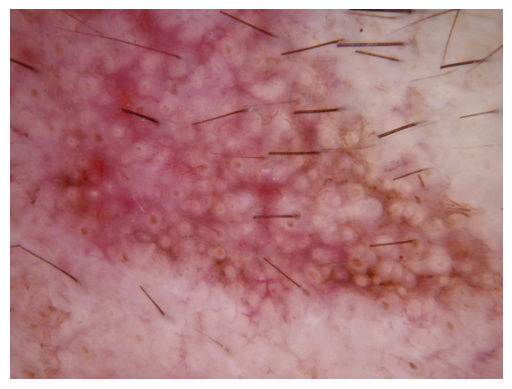

In [13]:
img_set = (list(data_dir_train.glob(class_names[0]+'/*.jpg'))[0])
plot_image(img_set)

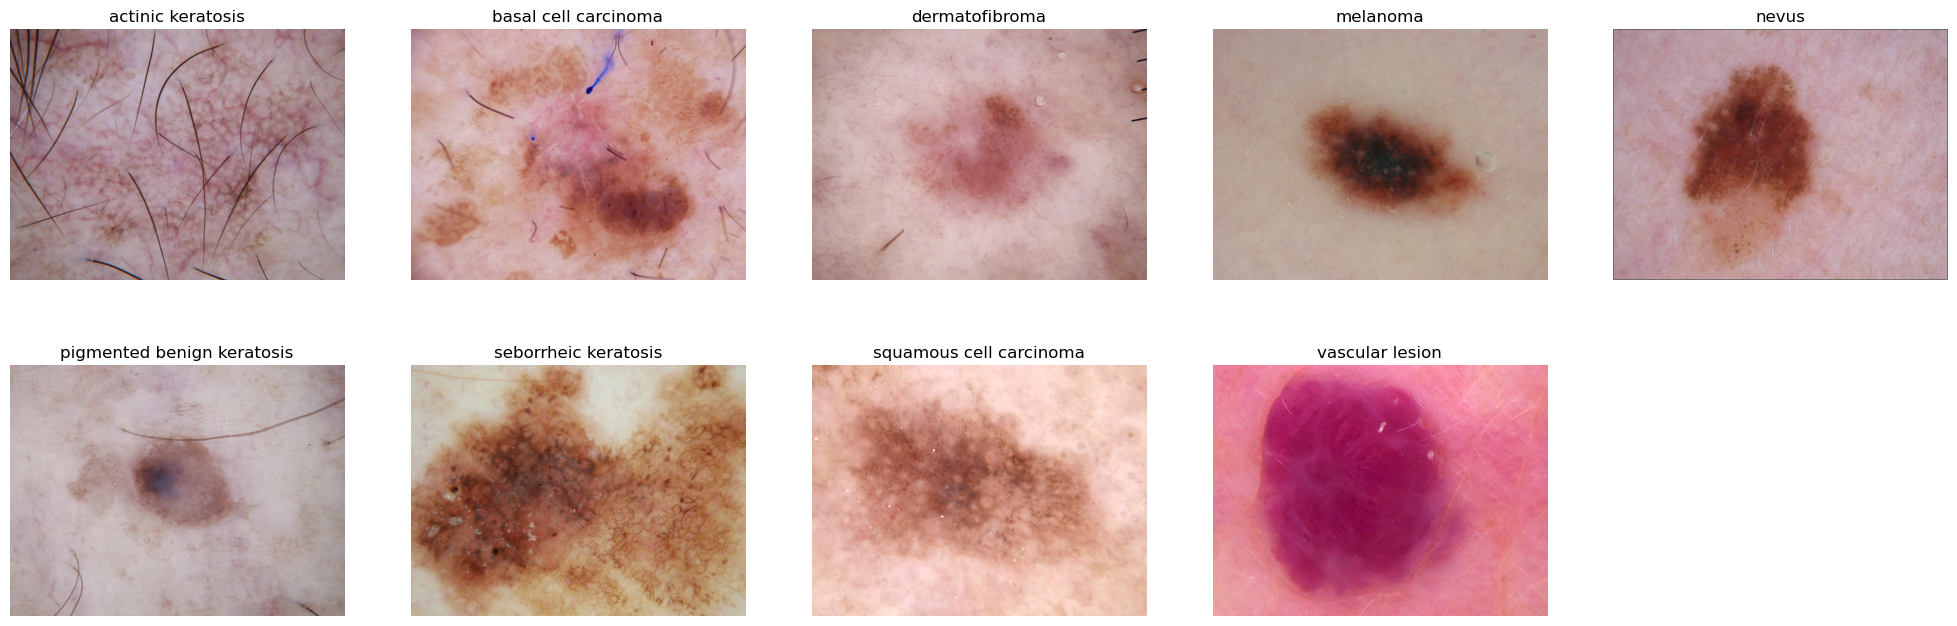

In [14]:
plt.figure(figsize=(25,8))
for i in range(len(class_names)):
  plt.subplot(2,5,i+1)
  img_name = str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1])
  plot_image(img_name, title=class_names[i])

### Visualize distribution of classes in the training dataset.

In [15]:
def class_distribution_count(directory):
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

In [16]:
df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<Axes: xlabel='No. of Image', ylabel='Class'>

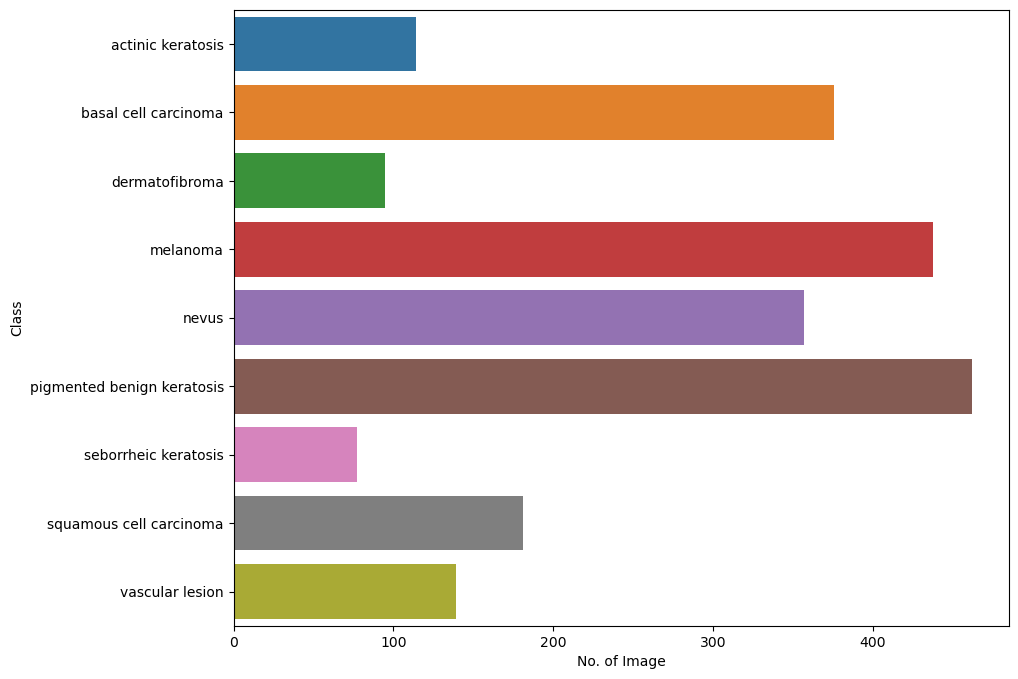

In [17]:
#Visualize the Number of image in each class.
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df, label="Class")

<h3>Observations:</h3>
<ol>
<li>class <b>seborrheic keratosis</b> has least number of samples ie. 77
<li>class <b>pigmented benign keratosis</b> dominate the data in terms of the proportionate number of samples ie. 462

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model Building & Training

In [19]:
def create_cnn_model():
    args_dict = {
        "num_classes" : num_classes,
        "img_height": img_height,
        "img_width": img_width
    }

    print("CNN model input args : ", args_dict)
    #Sequential allows you to create models layer-by-layer
    model=models.Sequential()

    # Rescaling Layer. scaling the pixel values from 0-255 to 0-1
    model.add(Rescaling(1./255,input_shape=(img_height,img_width,3)))

    #First Convulation layer
    model.add(layers.Conv2D(32,kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    #Second Convulation Layer
    model.add(layers.Conv2D(64,kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    #Third Convulation Layer
    model.add(layers.Conv2D(128,kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    #Dropout layer with 50% Fraction of the input units to drop.
    model.add(layers.Dropout(0.5))

    #Flatten Layer
    ##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
    model.add(layers.Flatten())

    #Dense Layer
    model.add(layers.Dense(128,activation='relu'))

    #Dropout layer with 25% Fraction of the input units to drop.
    model.add(layers.Dropout(0.25))

    #Dense Layer with softmax activation function.
    #Softmax is an activation function that scales numbers/logits into probabilities.
    model.add(layers.Dense(num_classes,activation='softmax'))

    model.summary()
    return model

In [20]:
def compile_model(model, loss_func='sparse_categorical_crossentropy'):
    model.summary()
    
    # choose an appropirate optimiser and loss function
    learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1,factor=0.2, min_lr=1e-7)

    #Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
    #categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.
    optimizer = Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer,loss=loss_func,metrics=["accuracy"])
    return learn_control

In [21]:
def train_model_with_epoch(model, epochs, train_ds, val_ds, callbacks):
    return model.fit(train_ds,validation_data=val_ds,epochs=epochs, callbacks=callbacks)

In [22]:
# Method to create plots of the loss and accuracy on the training and validation sets:
def plot_cnn_metrics(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [23]:
def plot_cnn_model(model, filename):
    # Plot the model
    plot_model(model, to_file=filename, show_shapes=True, show_layer_names=True)

In [24]:
model = create_cnn_model()

CNN model input args :  {'num_classes': 9, 'img_height': 180, 'img_width': 180}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                          

In [25]:
learn_control = compile_model(model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

In [29]:
history = train_model_with_epoch(model, 20, train_ds, val_ds, callbacks=[learn_control])

Epoch 1/20
169/169 [==============================] - 179s 1s/step - loss: 1.9560 - accuracy: 0.2608 - val_loss: 1.6313 - val_accuracy: 0.3734 - lr: 0.0010
Epoch 2/20
169/169 [==============================] - 177s 1s/step - loss: 1.5182 - accuracy: 0.4293 - val_loss: 1.3622 - val_accuracy: 0.4929 - lr: 0.0010
Epoch 3/20
169/169 [==============================] - 172s 1s/step - loss: 1.3265 - accuracy: 0.4898 - val_loss: 1.2329 - val_accuracy: 0.5174 - lr: 0.0010
Epoch 4/20
169/169 [==============================] - 188s 1s/step - loss: 1.1904 - accuracy: 0.5558 - val_loss: 1.0439 - val_accuracy: 0.5984 - lr: 0.0010
Epoch 5/20
169/169 [==============================] - 190s 1s/step - loss: 1.0722 - accuracy: 0.6068 - val_loss: 0.9948 - val_accuracy: 0.6481 - lr: 0.0010
Epoch 6/20
169/169 [==============================] - 175s 1s/step - loss: 0.9310 - accuracy: 0.6486 - val_loss: 0.9379 - val_accuracy: 0.6704 - lr: 0.0010
Epoch 7/20
169/169 [==============================] - 174s 1s/st

### Visualizing training results

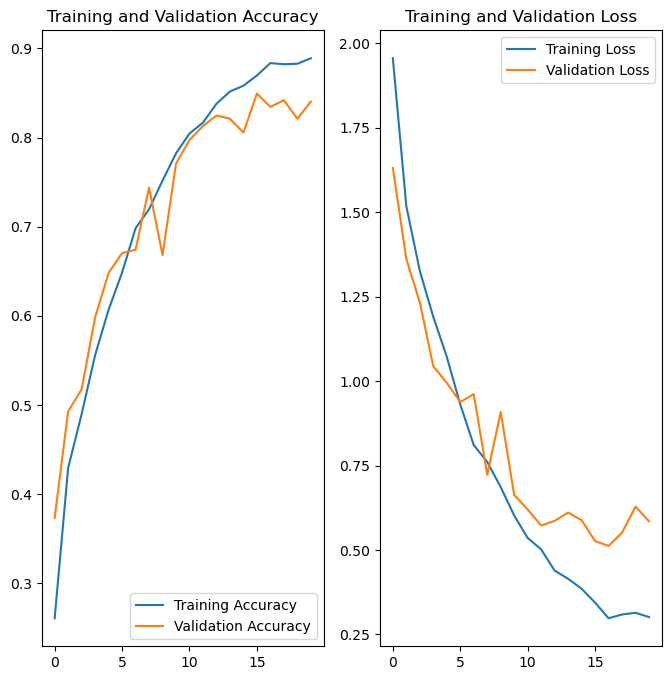

In [30]:
plot_cnn_metrics(history, epochs=20)

<b>Findings</b>
<ol>
<li>The Traing accuracy and validation accuracy are almost same, but very low which indicates that the model is underfitting
<li>Training loss is very low, but validation loss is fluctuating.
</ol>

Thus we can collect that the model is not good.<hr>

## Data augmentation

In [31]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# augumentation strategy with flip,rotate,skew,shift, zoom, brightness, contrast, saturation, hue
data_augmentation = tf.keras.Sequential(
  [
    RandomFlip("horizontal_and_vertical",
              input_shape=(img_height,
                          img_width,
                          3)),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.1)
  ]
)

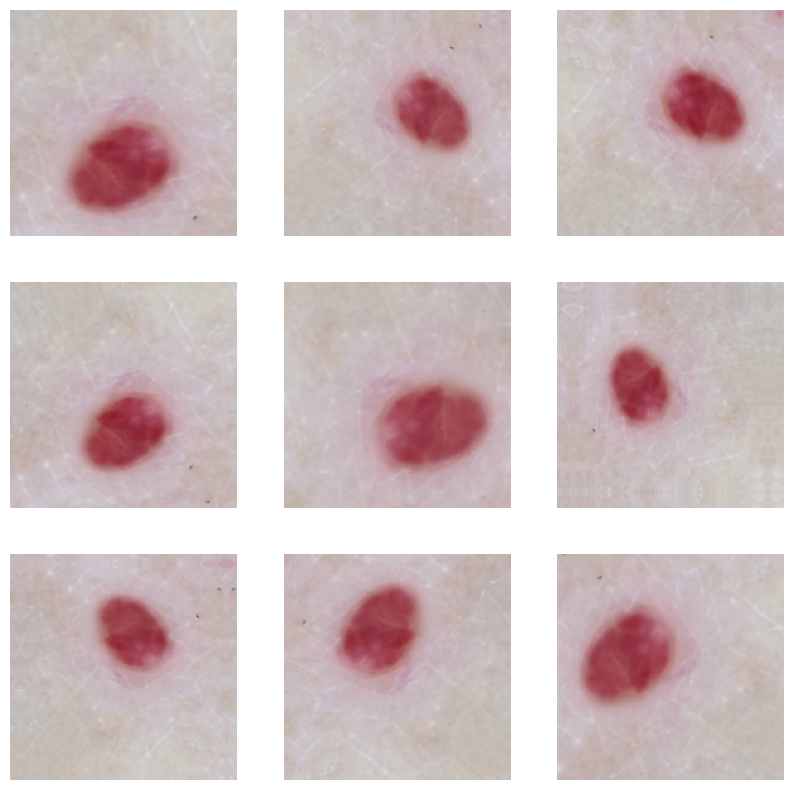

In [32]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [33]:
model = create_cnn_model()

CNN model input args :  {'num_classes': 9, 'img_height': 180, 'img_width': 180}
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                        

In [34]:
learn_control = compile_model(model)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 128)      

In [53]:
history = train_model_with_epoch(model, 20, train_ds, val_ds, callbacks=[learn_control])

Epoch 1/20
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 261s 201ms/step - accuracy: 0.3949 - loss: 1.5856 - val_accuracy: 0.7162 - val_loss: 0.7877 - learning_rate: 0.0010
Epoch 2/20
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 250s 194ms/step - accuracy: 0.7151 - loss: 0.7695 - val_accuracy: 0.8569 - val_loss: 0.4584 - learning_rate: 0.0010
Epoch 3/20
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 331s 256ms/step - accuracy: 0.8287 - loss: 0.4717 - val_accuracy: 0.9121 - val_loss: 0.2508 - learning_rate: 0.0010
Epoch 4/20
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 274s 212ms/step - accuracy: 0.8719 - loss: 0.3556 - val_accuracy: 0.9181 - val_loss: 0.2425 - learning_rate: 0.0010
Epoch 5/20
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 466s 360ms/step - accuracy: 0.8921 - loss: 0.3034 - val_accuracy: 0.9444 - val_loss: 0.1680 - learning_rate: 0.0010
Epoch 6/20
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 241s 186ms/step - accuracy: 0.9022 - loss: 0.2721 - val_accuracy: 0.9491 - val_loss: 0.1569 - learning_rate: 0.0010
Epoch 7/20
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 237s 183ms

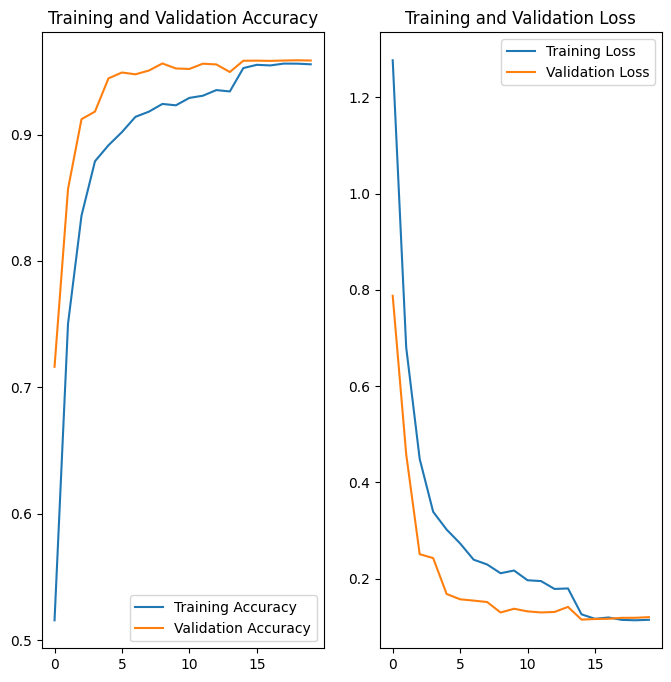

In [54]:
plot_cnn_metrics(history, epochs=20)

<b>Findings</b>
<ol>
<li>The Training accuracy and validation accuracy are almost same. This is a sign of good fit but the accuracy is still very low. The model requires more epochs to train with class imbalance handled.
</ol>

There is a class imbalance to solve this using a python package  Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [35]:
for i in class_names:
    source_dir = os.path.join(curr_dir_path, path_to_training_dataset.name, i)
    print("Source Directory : ", source_dir)
    
    p = Augmentor.Pipeline(source_dir)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Source Directory :  \Users\CL272FV\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis
Initialised with 114 image(s) found.
Output directory set to \Users\CL272FV\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x255B09868D0>: 100%|█| 500/500 [00:05<00:00, 95.44 Samples/


Source Directory :  \Users\CL272FV\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to \Users\CL272FV\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x255B11B2410>: 100%|█| 500/500 [00:05<00:00, 98.37 Samples/


Source Directory :  \Users\CL272FV\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma
Initialised with 95 image(s) found.
Output directory set to \Users\CL272FV\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x255B1113310>: 100%|█| 500/500 [00:04<00:00, 101.37 Samples


Source Directory :  \Users\CL272FV\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma
Initialised with 438 image(s) found.
Output directory set to \Users\CL272FV\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x25587C31AD0>: 100%|█| 500/500 [00:28<00:00, 17.63 Samples


Source Directory :  \Users\CL272FV\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus
Initialised with 357 image(s) found.
Output directory set to \Users\CL272FV\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x255B0A244D0>: 100%|█| 500/500 [00:30<00:00, 16.32 Samples


Source Directory :  \Users\CL272FV\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to \Users\CL272FV\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x255B4A25B50>: 100%|█| 500/500 [00:08<00:00, 61.91 Samples/


Source Directory :  \Users\CL272FV\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to \Users\CL272FV\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x255B4BE5F10>: 100%|█| 500/500 [00:15<00


Source Directory :  \Users\CL272FV\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to \Users\CL272FV\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x25580C9CE50>: 100%|█| 500/500 [00:07<00:00, 63.86 Samples/


Source Directory :  \Users\CL272FV\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion
Initialised with 139 image(s) found.
Output directory set to \Users\CL272FV\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x255B4C14910>: 100%|█| 500/500 [00:07<00:00, 63.52 Samples/


In [36]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

13500


# Model Building & training: 

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Training the model for ~20 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [37]:
# train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 15739 files belonging to 9 classes.
Using 12592 files for training.


In [38]:
# validation dataset 
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 15739 files belonging to 9 classes.
Using 3147 files for validation.


In [60]:
model = create_cnn_model()

CNN model input args :  {'num_classes': 9, 'img_height': 180, 'img_width': 180}


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
learn_control = compile_model(model, loss_func='categorical_crossentropy')

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# Training the model
history = train_model_with_epoch(model, 20, train_ds, val_ds, callbacks=[learn_control])

Epoch 1/20
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 302s 214ms/step - accuracy: 0.4015 - loss: 1.5680 - val_accuracy: 0.7762 - val_loss: 0.6293 - learning_rate: 0.0010
Epoch 2/20
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 307s 218ms/step - accuracy: 0.7511 - loss: 0.6859 - val_accuracy: 0.8930 - val_loss: 0.3138 - learning_rate: 0.0010
Epoch 3/20
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 307s 218ms/step - accuracy: 0.8441 - loss: 0.4290 - val_accuracy: 0.9266 - val_loss: 0.2164 - learning_rate: 0.0010
Epoch 4/20
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 301s 214ms/step - accuracy: 0.8690 - loss: 0.3626 - val_accuracy: 0.9386 - val_loss: 0.1838 - learning_rate: 0.0010
Epoch 5/20
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 294s 209ms/step - accuracy: 0.8992 - loss: 0.2776 - val_accuracy: 0.9491 - val_loss: 0.1503 - learning_rate: 0.0010
Epoch 6/20
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 874s 622ms/step - accuracy: 0.9085 - loss: 0.2509 - val_accuracy: 0.9426 - val_loss: 0.1683 - learning_rate: 0.0010
Epoch 7/20
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 300s 213ms

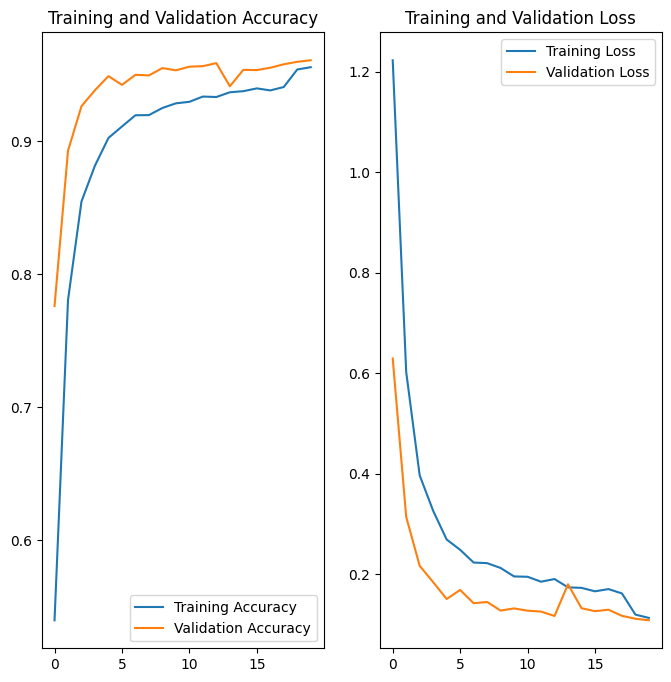

In [63]:
# Visualizing training results
plot_cnn_metrics(history,epochs=20)

In [64]:
plot_cnn_model(model, "keras_model.png")

<b>Observations:</b>
<ol>        
<li>The training accuracy and validation accuracy are almost same. This is a sign of good fit.
<li>The training loss and validation loss are almost same. This is a sign of good fit.
<li>The Validation accuracy is 0.87 which is good. The model is able to classify the images with 87% accuracy.
<li>The model's training accuracy displays a linear increase over time, whereas the validation accuracy plateaus at 50% accuracy during the training process.
<li>As the training epochs progress, the training loss decreases, however, the validation loss exhibits an opposing trend and increases.
<li>The visual representation of the model's performance indicates a substantial discrepancy between the training accuracy and validation accuracy, achieving a validation accuracy of approximately 50%.
<li>The noticeable difference between the training accuracy and validation accuracy is a clear indication of overfitting, indicating that the model may not generalize well to unseen data.
</ol>

## Model Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


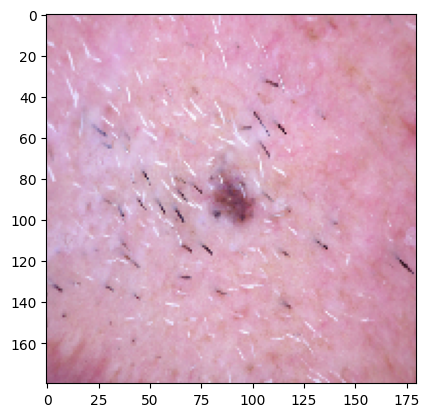

In [65]:
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )